# Match Quaia to (all) SDSS spectra.

In support of an *SDSS-V* spare-fiber proposal.

## License:
Copyright 2024 the authors. This code is licensed for re-use under the open-source MIT License.

## Authors:
- **Kate Storey-Fisher** (DIPC), working as volunteeer (!)
- **David W. Hogg** (Flatiron)

## Projects:
- Establish a target list for a possible *SDSS-V* spare-fiber program.
- Make plots relevant to that spare-fiber proposal.

## Bugs and known issues:
- This assumes that the DR16 "superset" file contains anything that might be relevant. This is probably false in detail.

In [1]:
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

import astropy
from astropy.table import Table, join, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

## Download and read data
This will take a while the first time you run it.

In [2]:
dirstr = "../data/"

In [3]:
fn = "quaia_G20.5.fits"
dfn = dirstr + fn
cmd = "curl -s -o " + dfn + " https://zenodo.org/records/8060755/files/" + fn
if not os.path.isfile(dfn + ".gz"):
    print(cmd)
    os.system(cmd)
    os.system("gzip -fv --best " + dfn)
dfn = dfn + ".gz"
foo = os.system("ls -al " + dfn)

-rw-r--r--  1 dhogg  staff  147777394 Jun 22 10:03 ../data/quaia_G20.5.fits.gz


In [4]:
quaia = Table.read(dfn)
print("Columns:", quaia.columns)
print("N =", len(quaia))

Columns: <TableColumns names=('source_id','unwise_objid','redshift_quaia','redshift_quaia_err','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','mag_w1_vg','mag_w2_vg','pm','pmra','pmdec','pmra_error','pmdec_error')>
N = 1295502


In [5]:
fns = "DR16Q_Superset_v3.fits"
dfns = dirstr + fns
cmd = "curl -s -o " + dfns + " https://data.sdss.org/sas/dr16/eboss/qso/DR16Q/" + fns
if not os.path.isfile(dfns + ".gz"):
    print(cmd)
    os.system(cmd)
    os.system("gzip -fv --best " + dfns)
dfns = dfns + ".gz"
foo = os.system("ls -al " + dfns)

-rw-r--r--  1 dhogg  staff  413489546 Jun 22 17:10 ../data/DR16Q_Superset_v3.fits.gz


In [6]:
sdss = Table.read(dfns)
sdss = sdss[sdss['OBJID'].mask==False] #remove ones with no objid
print("Columns:", sdss.columns)
print("N =", len(sdss))

Columns: <TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','PRIM_REC','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','

## Do cross-matching

In [7]:
def cross_match(ra1, dec1, ra2, dec2, separation):
    coords1 = SkyCoord(ra=ra1, dec=dec1, frame='icrs')    
    coords2 = SkyCoord(ra=ra2, dec=dec2, frame='icrs') 
    cross = astropy.coordinates.search_around_sky(coords1, coords2, separation) 
    index_list_1in2, index_list_2in1 = cross[0], cross[1] 
    return index_list_1in2, index_list_2in1

In [8]:
# Perform cross-match; 1 arcsec is a reasonable (but MAGIC) separation
separation = 1*u.arcsec
quaiaINsdss, sdssINquaia = cross_match(quaia['ra'], quaia['dec'],
                                    sdss['RA']*u.degree, sdss['DEC']*u.degree,
                                    separation=separation)
print(len(quaiaINsdss))

351602


In [9]:
# Make non-match list
quaiaNOTINsdss = np.ones(len(quaia)).astype(bool)
quaiaNOTINsdss[quaiaINsdss] = False
print(np.sum(quaiaNOTINsdss))

999906


In [10]:
quaia_exsdss = quaia[quaiaNOTINsdss]
print(len(quaia_exsdss))

999906


## Make plots

Text(0.5, 1.0, 'all of Quaia')

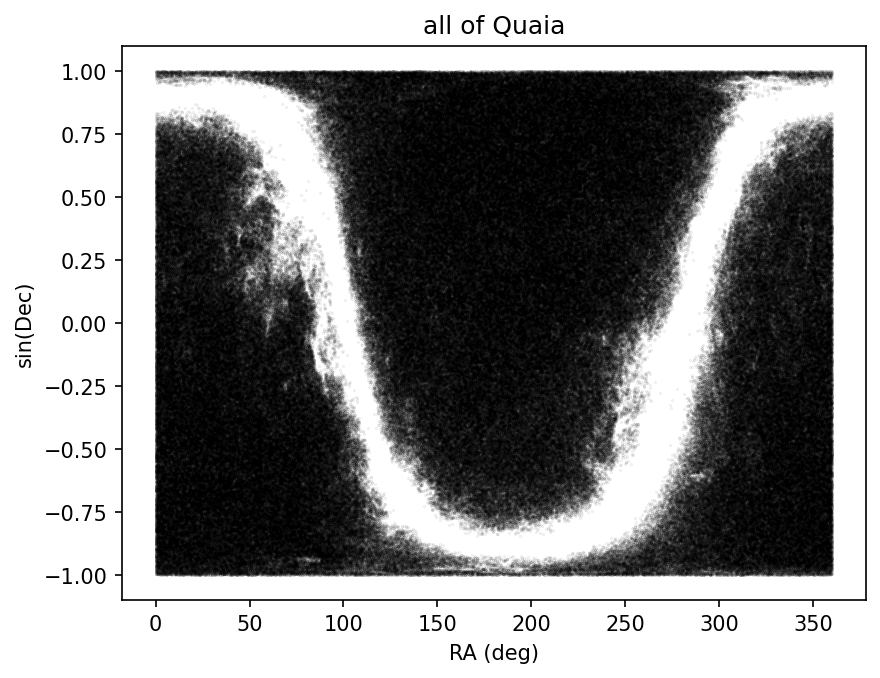

In [11]:
plt.scatter(quaia['ra'], np.sin(quaia['dec'] * np.pi / 180.), c="k", s=0.1, alpha=0.1)
plt.xlabel("RA (deg)")
plt.ylabel("sin(Dec)")
plt.title("all of Quaia")

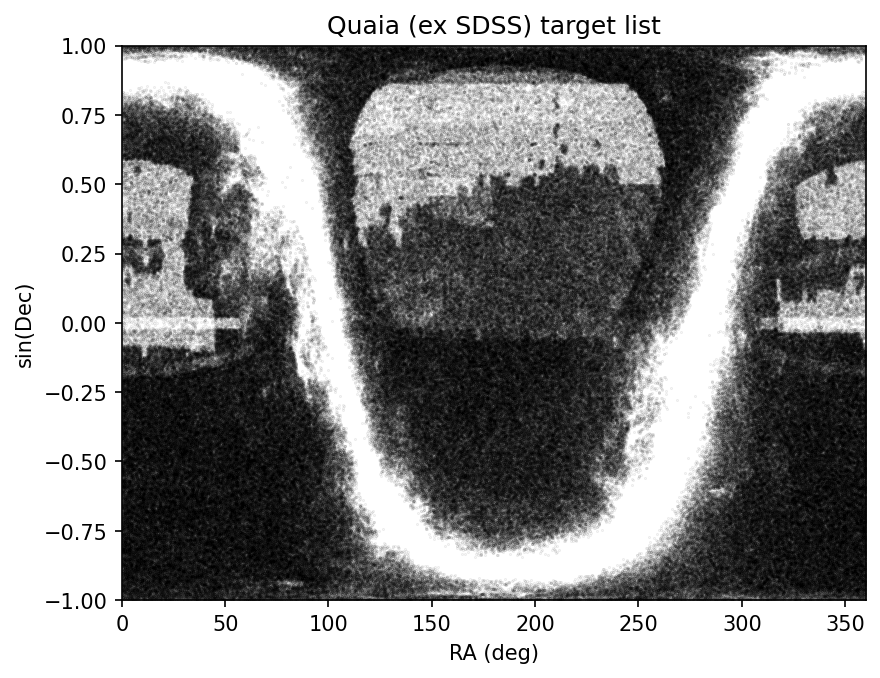

In [12]:
plt.scatter(quaia_exsdss['ra'], np.sin(quaia_exsdss['dec'] * np.pi / 180.), c="k", s=0.1, alpha=0.1)
plt.xlabel("RA (deg)")
plt.ylabel("sin(Dec)")
plt.xlim(0., 360.)
plt.ylim(-1., 1.)
title = "Quaia (ex SDSS) target list"
plt.title(title)
plt.savefig("quaia_exsdss.png")

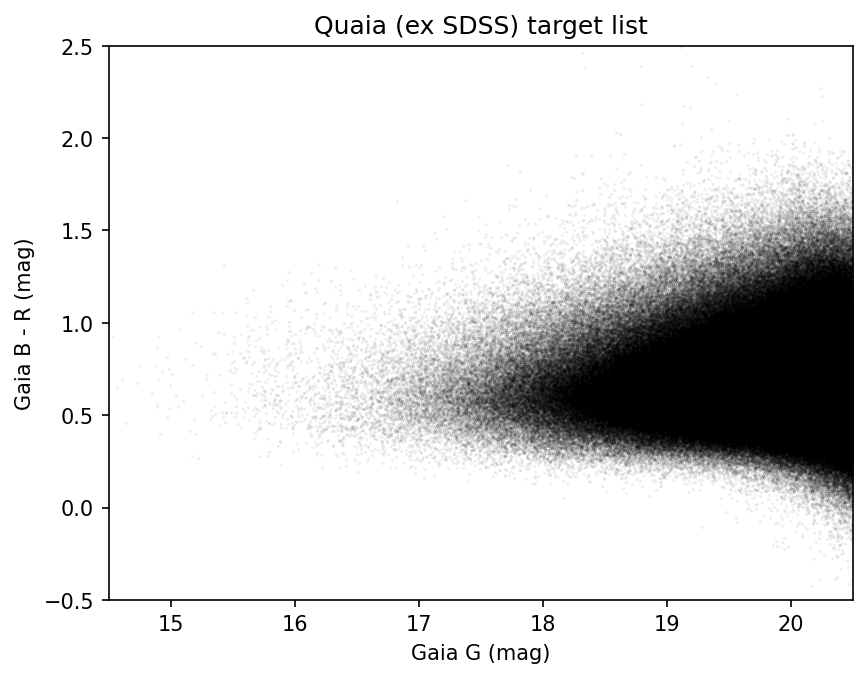

In [13]:
plt.scatter(quaia_exsdss['phot_g_mean_mag'], quaia_exsdss['phot_bp_mean_mag'] - quaia_exsdss['phot_rp_mean_mag'],
            c="k", s=0.1, alpha=0.1)
plt.xlabel("Gaia G (mag)")
plt.ylabel("Gaia B - R (mag)")
plt.xlim(14.5, 20.5)
plt.ylim(-0.5, 2.5)
plt.title(title)
plt.savefig("quaia_exsdss_mags.png")

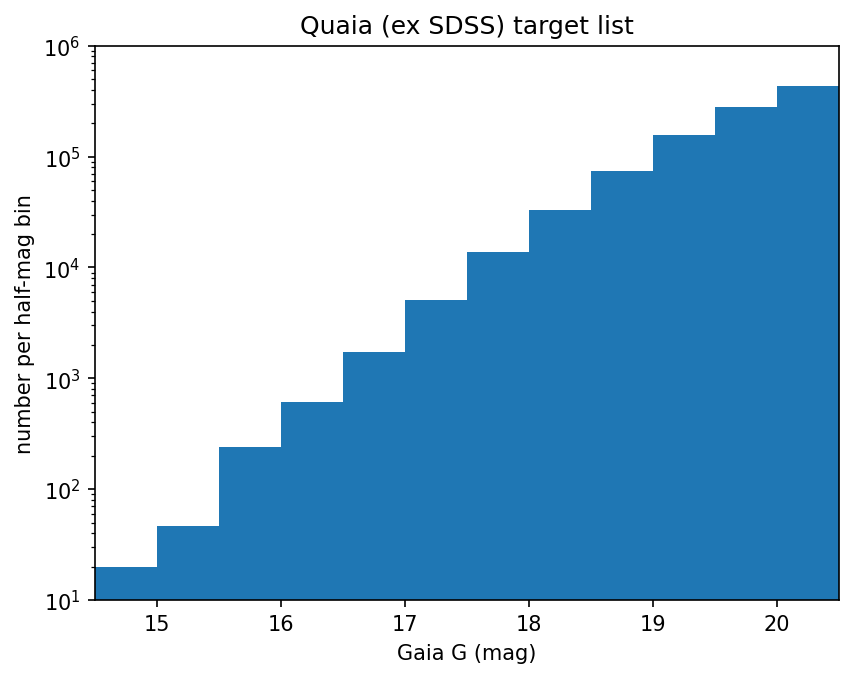

In [14]:
plt.hist(quaia_exsdss['phot_g_mean_mag'], bins=np.arange(13., 22., 0.5))
plt.xlabel("Gaia G (mag)")
plt.ylabel("number per half-mag bin")
plt.xlim(14.5, 20.5)
plt.ylim(1e1, 1e6)
plt.semilogy()
plt.title(title)
plt.savefig("quaia_exsdss_mag_hist.png")

## Write target-list file

In [15]:
print(quaia_exsdss.dtype)
print(quaia_exsdss.dtype.name)

[('source_id', '>i8'), ('unwise_objid', 'S16'), ('redshift_quaia', '>f8'), ('redshift_quaia_err', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('l', '>f8'), ('b', '>f8'), ('phot_g_mean_mag', '>f4'), ('phot_bp_mean_mag', '>f4'), ('phot_rp_mean_mag', '>f4'), ('mag_w1_vg', '>f8'), ('mag_w2_vg', '>f8'), ('pm', '>f8'), ('pmra', '>f8'), ('pmdec', '>f8'), ('pmra_error', '>f4'), ('pmdec_error', '>f4')]
void1056


In [16]:
fn = "bhm_quaia.fits"
dfn = dirstr + fn
quaia_exsdss.write(dfn, format="fits")
foo = os.system("gzip -fv --best " + dfn)

../data/bhm_quaia.fits:	   13.4% -- replaced with ../data/bhm_quaia.fits.gz
